In [44]:
!pip install keras

In [45]:
!pip install keras-tuner

In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as ml
%matplotlib inline
ml.style.use('ggplot')
# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix,accuracy_score
# Keras
import keras
from keras.models import Sequential
from keras.layers import Dense,LeakyReLU,PReLU,ELU,Dropout
# Tensorflow-keras : Specifically for hyperparameter tuning portion of the NB
from tensorflow import keras
from tensorflow.keras import layers
from kerastuner.tuners import RandomSearch

#### BUILDING AN ANN : FIRST TIME

#### Import dataset, preprocess, split and standardize the data

In [47]:
data = pd.read_csv('/content/drive/MyDrive/Churn_Modelling.csv')
data.head(10)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
5,6,15574012,Chu,645,Spain,Male,44,8,113755.78,2,1,0,149756.71,1
6,7,15592531,Bartlett,822,France,Male,50,7,0.00,2,1,1,10062.80,0
7,8,15656148,Obinna,376,Germany,Female,29,4,115046.74,4,1,0,119346.88,1
8,9,15792365,He,501,France,Male,44,4,142051.07,2,0,1,74940.50,0
9,10,15592389,H?,684,France,Male,27,2,134603.88,1,1,1,71725.73,0


In [48]:
# Separate out X and Y first, then perform encoding.
X,Y = data.iloc[:,3:13],data.iloc[:,13]
# Create dummy variables
geo,gender = pd.get_dummies(X['Geography'],drop_first=True),pd.get_dummies(X['Gender'],drop_first=True)
# Concat the dataframes and drop the original columns
X = pd.concat([X,geo,gender],axis=1)
X = X.drop(columns=['Geography','Gender'],axis=1)
X.head(10)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Germany,Spain,Male
0,619,42,2,0.00,1,1,1,101348.88,0,0,0
1,608,41,1,83807.86,1,0,1,112542.58,0,1,0
2,502,42,8,159660.80,3,1,0,113931.57,0,0,0
3,699,39,1,0.00,2,0,0,93826.63,0,0,0
4,850,43,2,125510.82,1,1,1,79084.10,0,1,0
5,645,44,8,113755.78,2,1,0,149756.71,0,1,1
6,822,50,7,0.00,2,1,1,10062.80,0,0,1
7,376,29,4,115046.74,4,1,0,119346.88,1,0,0
8,501,44,4,142051.07,2,0,1,74940.50,0,0,1
9,684,27,2,134603.88,1,1,1,71725.73,0,0,1


In [49]:
trainx,testx,trainy,testy = train_test_split(X,Y,test_size=0.2,random_state=0)
# Standardization
scaler = StandardScaler()
trainx,testx = scaler.fit_transform(trainx),scaler.fit_transform(testx)

#### Build the ANN model

In [50]:
# Initialize the model
model = Sequential()
# Add the i/p layer and the first hidden layer
model.add(Dense(units=6,activation='relu',kernel_initializer='he_uniform',input_dim=11))
# Second and o/p layers
model.add(Dense(units=6,activation='relu',kernel_initializer='he_uniform'))
model.add(Dense(units=1,activation='sigmoid',kernel_initializer='glorot_uniform'))
# Compile and fit the ANN on trainx,trainy
model.compile(optimizer='Adamax',loss='binary_crossentropy',metrics=['accuracy'])
model_history = model.fit(trainx,trainy,validation_split=0.33, batch_size = 10, epochs = 100)
print(model_history.history.keys())

Epoch 1/100
536/536 [==============================] - 1s 2ms/step - loss: 0.5684 - accuracy: 0.7346 - val_loss: 0.5129 - val_accuracy: 0.7963
Epoch 2/100
536/536 [==============================] - 1s 1ms/step - loss: 0.5133 - accuracy: 0.7926 - val_loss: 0.4839 - val_accuracy: 0.8023
Epoch 3/100
536/536 [==============================] - 1s 2ms/step - loss: 0.4877 - accuracy: 0.8012 - val_loss: 0.4697 - val_accuracy: 0.8031
Epoch 4/100
536/536 [==============================] - 1s 2ms/step - loss: 0.4700 - accuracy: 0.7992 - val_loss: 0.4618 - val_accuracy: 0.8008
Epoch 5/100
536/536 [==============================] - 1s 1ms/step - loss: 0.4645 - accuracy: 0.7973 - val_loss: 0.4566 - val_accuracy: 0.8008
Epoch 6/100
536/536 [==============================] - 1s 1ms/step - loss: 0.4510 - accuracy: 0.8029 - val_loss: 0.4532 - val_accuracy: 0.8016
Epoch 7/100
536/536 [==============================] - 1s 2ms/step - loss: 0.4508 - accuracy: 0.8023 - val_loss: 0.4505 - val_accuracy: 0.8023

#### Plot the summary

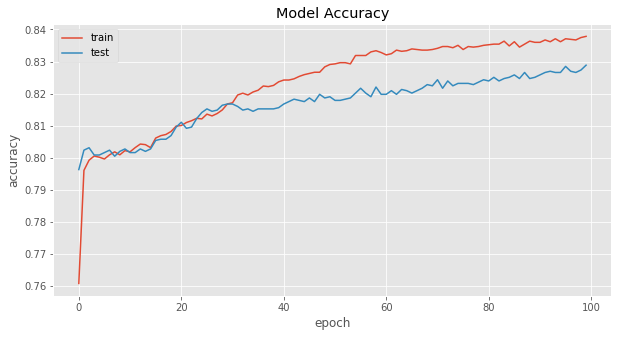

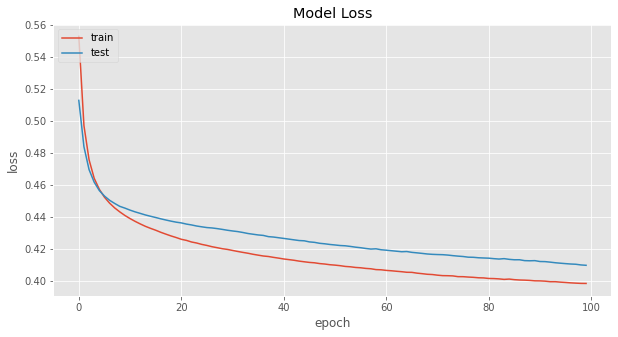

In [51]:
# Summarize the history for accuracy and loss
# Accuracy
plt.figure(figsize=(10,5))
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Loss
plt.figure(figsize=(10,5))
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### Predict and evaluate the model

In [52]:
# Predicting the test set results
y_pred = model.predict(testx)
# Fetch predictions where probability > 0.5
y_pred = (y_pred > 0.5)
# Create the confusion matrix
cm = confusion_matrix(testy, y_pred)
print("Confusion Matrix :\n",cm)
# Calculate the accuracy
score=accuracy_score(y_pred,testy)
print("\nAccuracy Score = ",score)

Confusion Matrix :
 [[1538   57]
 [ 261  144]]

Accuracy Score =  0.841


#### HYPERPARAMETER TUNING USING KERAS TUNER

#### Import data and split appropriately

In [53]:
dataset = pd.read_csv('/content/drive/MyDrive/Real_Combine.csv')
dataset.head(10)

,T,TM,Tm,SLP,H,VV,V,VM,PM 2.5
0,7.4,9.8,4.8,1017.6,93.0,0.5,4.3,9.4,219.720833
1,7.8,12.7,4.4,1018.5,87.0,0.6,4.4,11.1,182.187500
2,6.7,13.4,2.4,1019.4,82.0,0.6,4.8,11.1,154.037500
3,8.6,15.5,3.3,1018.7,72.0,0.8,8.1,20.6,223.208333
4,12.4,20.9,4.4,1017.3,61.0,1.3,8.7,22.2,200.645833
5,16.0,25.2,10.0,1013.2,79.0,0.6,4.8,11.1,285.225000
6,13.4,21.0,9.2,1015.1,87.0,0.5,1.5,7.6,236.825000
7,14.3,22.6,6.6,1016.3,76.0,0.8,0.4,3.5,276.908333
8,12.7,18.9,7.3,1021.2,76.0,1.8,6.1,16.5,108.000000
9,11.9,18.9,6.3,1020.1,76.0,1.1,8.3,20.6,107.625000


In [54]:
X_air = dataset.iloc[:,:-1]
Y_air = dataset.iloc[:,-1]

#### What are the hyperparameters we aim to tune ?
1. No. of hidden layers
2. No. of neurons in each hidden layer
3. Learning rate

In [55]:
# Function to build the model
def build_model(hp):
  # hp : hyperparameter
  model = keras.Sequential()
  # Hyperparameter : Num of layers
  for i in range(hp.Int('num_layers',2,20)):
    # Hyperparameter : No. of neurons
    model.add(layers.Dense(units=hp.Int('units_' + str(i),
                                            min_value=32,
                                            max_value=512,
                                            step=32),
                               activation='relu'))
  model.add(layers.Dense(1, activation='linear'))
  # Hyperparameter : Learning rate
  # Remember, choice of loss and metrics are different as this is a regression problem
  model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
        loss='mean_absolute_error',
        metrics=['mean_absolute_error'])
  return model

#### Tuning : kerastuner's RandomSearch

In [56]:
# Using kerastuner to tune the hyperparameters
tuner = RandomSearch(
    build_model,
    objective='val_mean_absolute_error',
    max_trials=3,
    executions_per_trial=2,
    directory='project',
    project_name='Air Quality Index'
)
tuner.search_space_summary()

INFO:tensorflow:Reloading Oracle from existing project project/Air Quality Index/oracle.json
INFO:tensorflow:Reloading Tuner from project/Air Quality Index/tuner0.json
Search space summary
Default search space size: 15
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 20, 'step': 1, 'sampling': None}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}
units_2 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
units_3 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
units_4 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 

#### Split data and train the tuner on training data

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X_air, Y_air, test_size=0.3, random_state=0)
tuner.search(X_train,y_train,epochs=5,validation_data=(X_test,y_test))

INFO:tensorflow:Oracle triggered exit


In [58]:
tuner.results_summary()

Results summary
Results in project/Air Quality Index
Showing 10 best trials
Objective(name='val_mean_absolute_error', direction='min')
Trial summary
Hyperparameters:
num_layers: 10
units_0: 288
units_1: 128
learning_rate: 0.001
units_2: 128
units_3: 320
units_4: 192
units_5: 32
units_6: 288
units_7: 288
units_8: 416
units_9: 192
units_10: 96
units_11: 64
units_12: 160
Score: nan
Trial summary
Hyperparameters:
num_layers: 13
units_0: 416
units_1: 160
learning_rate: 0.001
units_2: 96
units_3: 192
units_4: 32
units_5: 32
units_6: 32
units_7: 32
units_8: 32
units_9: 32
units_10: 32
units_11: 32
units_12: 32
Score: nan
Trial summary
Hyperparameters:
num_layers: 4
units_0: 32
units_1: 160
learning_rate: 0.001
units_2: 32
units_3: 32
Score: nan
Trial summary
Hyperparameters:
num_layers: 12
units_0: 96
units_1: 256
learning_rate: 0.001
units_2: 224
units_3: 96
units_4: 256
units_5: 320
units_6: 288
units_7: 256
units_8: 384
units_9: 320
units_10: 384
units_11: 320
units_12: 96
Score: nan
Trial